### Installing and importing the important libraries

In [ ]:
%%capture
!pip install keras==2.4.3
!pip install opencv-python
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import random

import os

# Emotion recognition using CNN

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/train-fer/train',
                                                   color_mode='grayscale',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle = True
                                                  )

Found 26957 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/train-fer/train',
                                                  color_mode='grayscale',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64,
                                                  shuffle = False
                                                 )

Found 6736 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/test-2/test',
                                                  color_mode='grayscale',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  shuffle = False
                                               )

Found 8421 images belonging to 7 classes.


In [ ]:
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Fetching the next batch of images and labels
img, label = next(train_dataset)

In [ ]:
# Initialize the model
model_cnn = Sequential()

# Add layers
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.1))

model_cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.1))

model_cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.1))

model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(7, activation='softmax'))

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_cnn.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
# Compile the model
model_cnn.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# Print the model summary
print(model_cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 128)       0

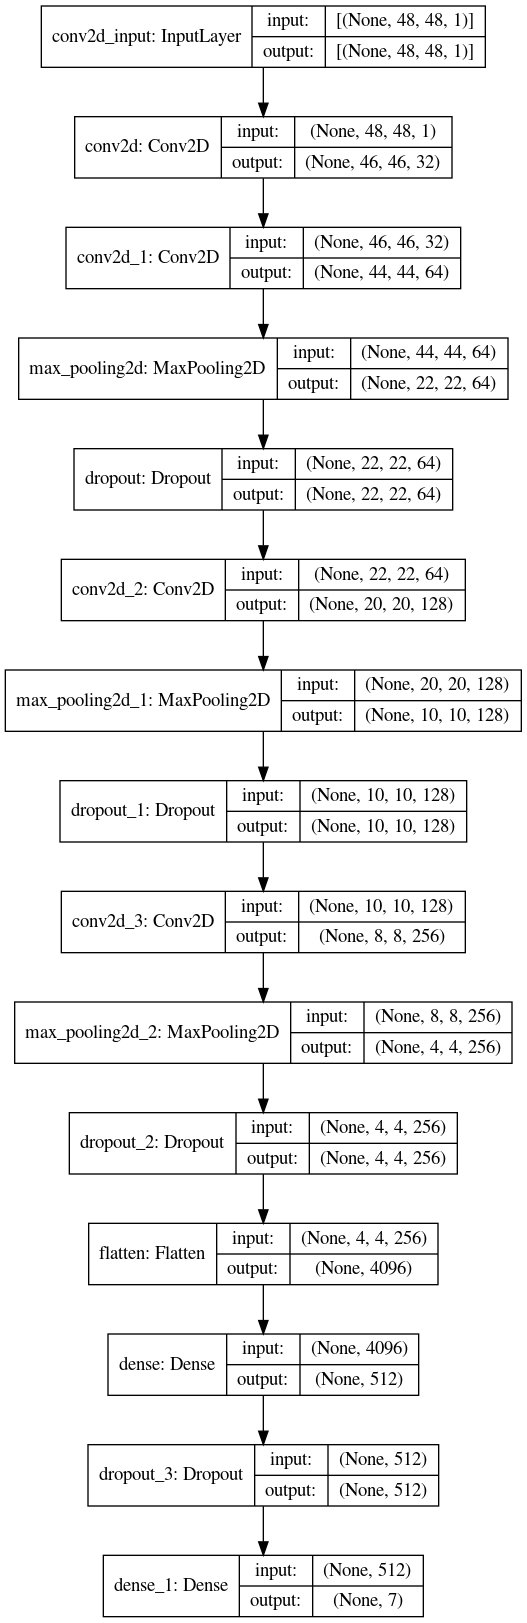

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model_cnn, to_file='cnn.png', show_shapes=True,show_layer_names=True)
Image(filename='cnn.png')

In [ ]:
# Count the number of training and validation images
num_train_imgs = train_dataset.samples
num_valid_imgs = valid_dataset.samples

print(f"Number of training images: {num_train_imgs}")
print(f"Number of validation images: {num_valid_imgs}")

Number of training images: 26957
Number of validation images: 6736


In [ ]:
history=model_cnn.fit(train_dataset,validation_data=valid_dataset,epochs = 4,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/4
422/422 [==============================] - 244s 574ms/step - loss: 1.8708 - accuracy: 0.8580 - precision: 0.4649 - recall: 0.0162 - auc: 0.5979 - f1_score: 0.0288 - val_loss: 1.5239 - val_accuracy: 0.8720 - val_precision: 0.7425 - val_recall: 0.1588 - val_auc: 0.7879 - val_f1_score: 0.2336
Epoch 2/4
422/422 [==============================] - 232s 549ms/step - loss: 1.4892 - accuracy: 0.8713 - precision: 0.6930 - recall: 0.1773 - auc: 0.8010 - f1_score: 0.2788 - val_loss: 1.3903 - val_accuracy: 0.8773 - val_precision: 0.7070 - val_recall: 0.2414 - val_auc: 0.8302 - val_f1_score: 0.3331
Epoch 3/4
422/422 [==============================] - 228s 539ms/step - loss: 1.3273 - accuracy: 0.8810 - precision: 0.7258 - recall: 0.2683 - auc: 0.8475 - f1_score: 0.3888 - val_loss: 1.2920 - val_accuracy: 0.8852 - val_precision: 0.7324 - val_recall: 0.3097 - val_auc: 0.8548 - val_f1_score: 0.4058
Epoch 4/4
422/422 [==============================] - 225s 533ms/step - loss: 1.2041 - accuracy: 0

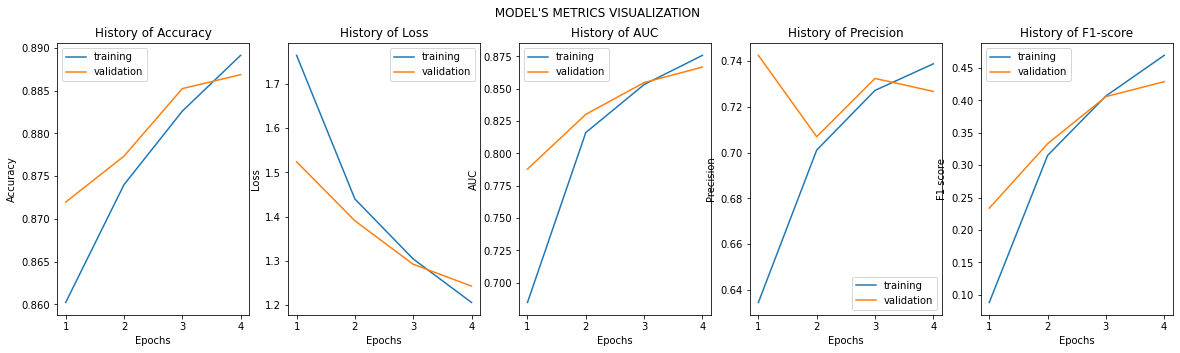

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

* **Accuracy** : Both training and validation accuracy improve over epochs. Validation accuracy starts higher than training accuracy but converges closely in later epochs, indicating effective learning and generalization to the validation set.
* **Loss** : Training and validation loss consistently decrease over epochs. However, the validation loss decreases more rapidly and reaches lower values earlier than the training loss. This suggests the model is not overfitting and optimization is effective.
* **AUC** : Training and validation AUC values increase steadily over epochs, with validation AUC consistently slightly higher than training AUC. This indicates strong model performance in distinguishing between classes, reflecting good generalization.
* **Precision** : Validation precision exhibits fluctuations, particularly in the early epochs, with a slight drop before stabilizing. Training precision improves steadily, eventually converging towards validation precision, showing progress in the model's ability to classify positive examples correctly.
* **F1-score** : Both training and validation F1-scores improve consistently over epochs. While the validation F1-score stabilizes after an initial fluctuation, training F1-score increases steadily and aligns closely with validation performance in the final epochs. This indicates the model is effectively balancing precision and recall.<br><br>
===> The trends across all metrics—accuracy, loss, AUC, precision, and F1-score—show consistent improvement and convergence between training and validation datasets, suggesting that the model is learning effectively and generalizing well. The fluctuations in some metrics (like precision and F1-score) in the initial epochs may be due to the variability in the data but stabilize as training progresses. Overall, the model is well-tuned, with no signs of overfitting, and demonstrates strong performance across metrics.

In [ ]:
# Evaluate the model on the test set
results = model_cnn.evaluate(test_dataset, verbose=1)

132/132 [==============================] - 31s 231ms/step - loss: 1.1786 - accuracy: 0.8922 - precision: 0.7475 - recall: 0.3705 - auc: 0.8810 - f1_score: 0.4610


===> The model performs well overall, with high accuracy (0.8922), precision (0.7475), and AUC (0.8810), indicating strong generalization and reliable classification. However, the low recall (0.3705) and moderate F1-score (0.4610) suggest it struggles to capture all true positives.

### Example of a prediction subset

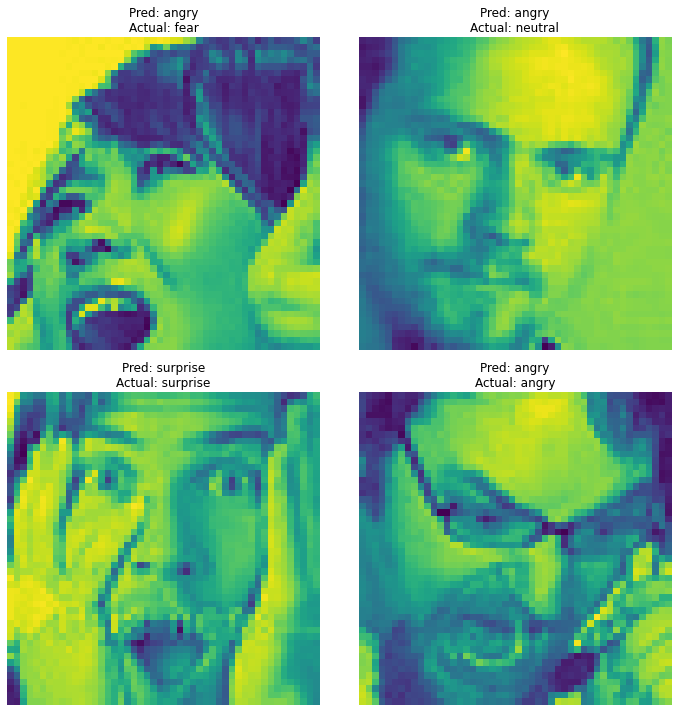

In [ ]:
# Get the class indices from the dataset
class_indices = test_dataset.class_indices
class_names = list(class_indices.keys())

# Dictionary to store one image per class
selected_images = {}
selected_labels = {}

# Extract a batch from the test_dataset
for batch_images, batch_labels in test_dataset:
    for image, label in zip(batch_images, batch_labels):
        # Get the actual class index
        actual_class_index = np.argmax(label)

        # If this class is not yet in the selected_images, add it
        if actual_class_index not in selected_images:
            selected_images[actual_class_index] = image
            selected_labels[actual_class_index] = label

        # Stop if we've selected one image per class
        if len(selected_images) == len(class_names):
            break
    if len(selected_images) == len(class_names):
        break

# Select up to 4 classes randomly
selected_classes = list(selected_images.keys())
random_classes = random.sample(selected_classes, min(4, len(selected_classes)))

# Create a figure for displaying the images
plt.figure(figsize=(10, 10))

# Loop through the selected classes
for i, class_index in enumerate(random_classes):
    image = selected_images[class_index]
    label = selected_labels[class_index]

    # Reshape and scale the image if necessary
    image_input = np.expand_dims(image, axis=0)

    # Predict using the trained model
    predictions = model_cnn.predict(image_input)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]

    # Get the actual class name
    actual_class_name = class_names[class_index]

    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {predicted_class_name}\nActual: {actual_class_name}")
    plt.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Correlation Matrix

#### Between validation and prediction

107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step


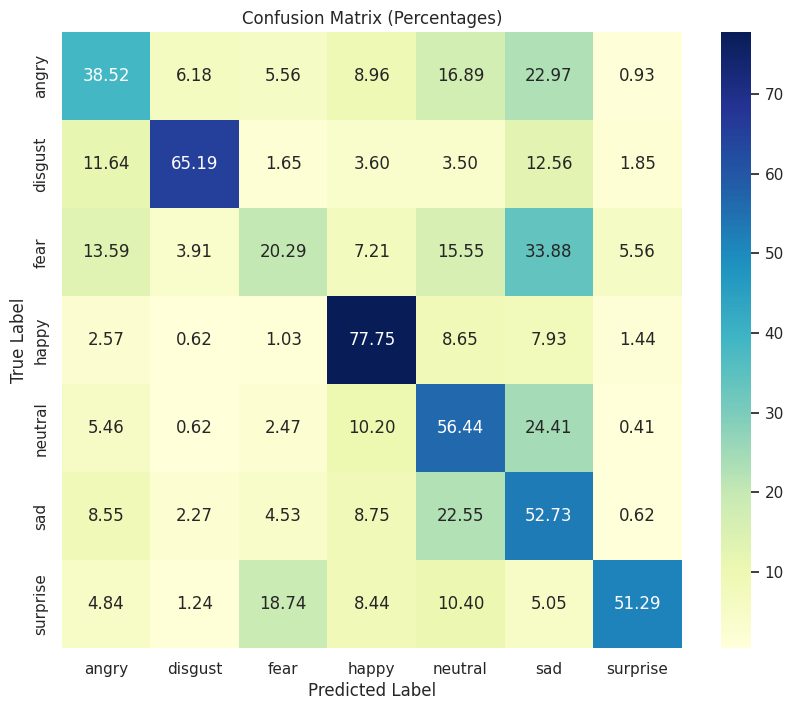

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = valid_dataset.classes
validation_pred_probs = model_cnn.predict(valid_dataset)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)

# Normalize the confusion matrix to percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

# Get class names
class_names = list(train_dataset.class_indices.keys())

# Plot the heatmap
sns.set()
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()


===>  confusion matrix shows that all classes are predicted well overall, with strong true positive counts across most emotions, particularly "happy" and "disgust". While some minor misclassifications exist, the model demonstrates a good ability to distinguish between the different emotion categories effectively.

#### Between test and prediction

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step


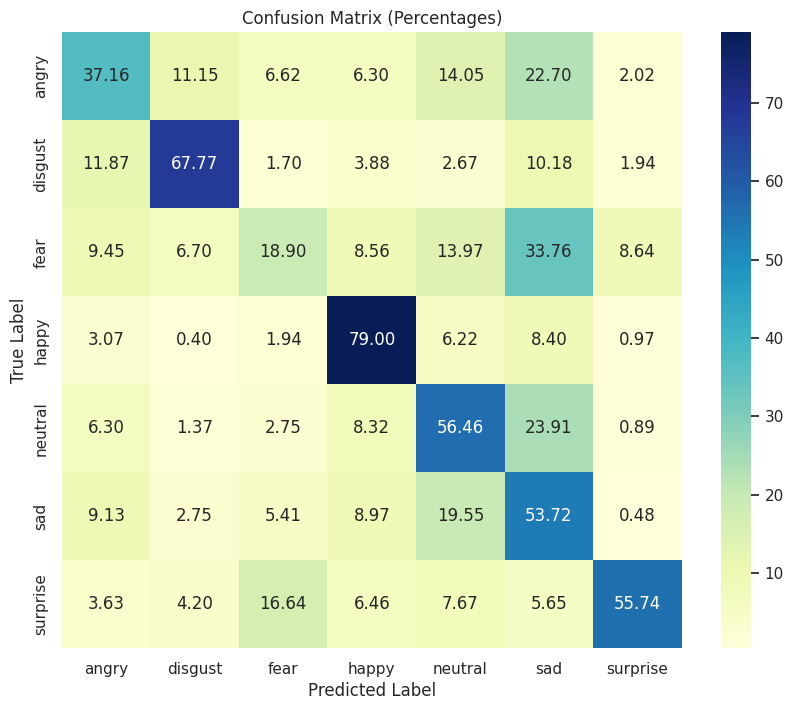

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = test_dataset.classes
validation_pred_probs = model_cnn.predict(test_dataset)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)

# Normalize the confusion matrix to percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

# Get class names
class_names = list(train_dataset.class_indices.keys())

# Plot the heatmap
sns.set()
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages)')
plt.show()


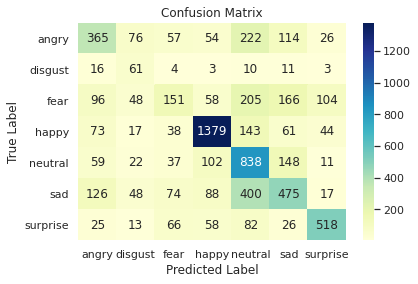

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = test_dataset.classes
validation_pred_probs = model_cnn.predict(test_dataset)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_dataset.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

===> The model performs best at recognizing "Happy" (1379 correctly classified) and has some challenges with "Disgust". Overall, the matrix shows the ability of the model to predict correcttly the different classes.

### ROC Curve

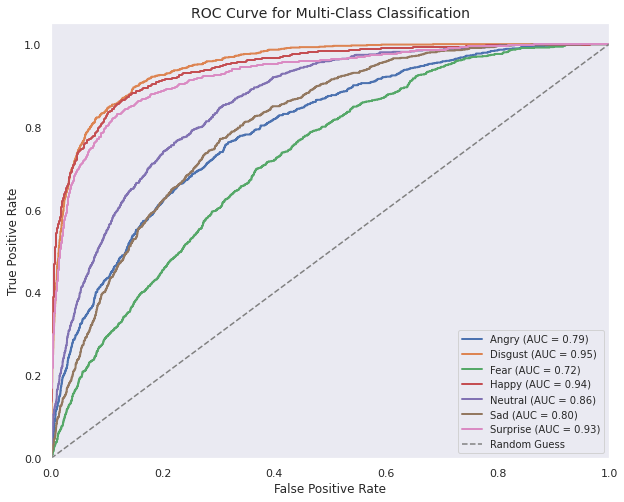

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels and predicted probabilities
y_true = []
y_pred_prob = []

# Collect data from the validation set
for img, label in valid_dataset:
    y_true.extend(label)  # True labels
    y_pred_prob.extend(model_cnn.predict(img))  # Predicted probabilities
    if len(y_true) >= valid_dataset.samples:  # Stop when we cover the full validation set
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(7))  # 7 classes (0 to 6)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_label} (AUC = {roc_auc:.2f})')

# Add a diagonal line for random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5, label='Random Guess')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Multi-Class Classification', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


===> The ROC curve shows that the model performs exceptionally well in classifying "Disgust" (AUC = 0.95) and "Happy" (AUC = 0.94), while struggling a bit with "Fear" (AUC = 0.72). Overall, the model demonstrates good classification capability.

## Training without data augmentation during the train

In [ ]:
train_datagen_WA = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

valid_datagen_WA = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

test_datagen_WA = ImageDataGenerator(
    rescale=1.0 / 255
)

In [ ]:
train_dataset_WA = train_datagen_WA.flow_from_directory(
                        directory='../input/train-fer/train',
                        color_mode='grayscale',
                        target_size=(48, 48),
                        class_mode='categorical',
                        subset='training',
                        batch_size=64,
                        shuffle=True
                    )

Found 26957 images belonging to 7 classes.


In [ ]:
valid_dataset_WA = valid_datagen_WA.flow_from_directory(
                    directory='../input/train-fer/train',
                    color_mode='grayscale',
                    target_size=(48, 48),
                    class_mode='categorical',
                    subset='validation',
                    batch_size=64,
                    shuffle=False
                )

Found 6736 images belonging to 7 classes.


In [ ]:
test_dataset_WA = test_datagen_WA.flow_from_directory(
                    directory='../input/test-fer/test',
                    color_mode='grayscale',
                    target_size=(48, 48),
                    class_mode='categorical',
                    batch_size=64,
                    shuffle=False
                )

Found 6838 images belonging to 7 classes.


In [ ]:
# Initialize the model
model_cnn_WA = Sequential()

# Add layers
model_cnn_WA.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model_cnn_WA.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn_WA.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_WA.add(Dropout(0.1))

model_cnn_WA.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_cnn_WA.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_WA.add(Dropout(0.1))

model_cnn_WA.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model_cnn_WA.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_WA.add(Dropout(0.1))

model_cnn_WA.add(Flatten())
model_cnn_WA.add(Dense(512, activation='relu'))
model_cnn_WA.add(Dropout(0.2))
model_cnn_WA.add(Dense(7, activation='softmax'))

In [ ]:
# Compile the model
model_cnn_WA.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history1=model_cnn_WA.fit(train_dataset_WA,validation_data=valid_dataset_WA,epochs = 4 ,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/4
422/422 [==============================] - 211s 500ms/step - loss: 1.7963 - accuracy: 0.8589 - precision: 0.6087 - recall: 0.0354 - auc: 0.6697 - f1_score: 0.0622 - val_loss: 1.6058 - val_accuracy: 0.8668 - val_precision: 0.7212 - val_recall: 0.1099 - val_auc: 0.7609 - val_f1_score: 0.1758
Epoch 2/4
422/422 [==============================] - 218s 517ms/step - loss: 1.4447 - accuracy: 0.8739 - precision: 0.7001 - recall: 0.2049 - auc: 0.8150 - f1_score: 0.3126 - val_loss: 1.4310 - val_accuracy: 0.8769 - val_precision: 0.6867 - val_recall: 0.2542 - val_auc: 0.8208 - val_f1_score: 0.3466
Epoch 3/4
422/422 [==============================] - 220s 521ms/step - loss: 1.2498 - accuracy: 0.8853 - precision: 0.7259 - recall: 0.3172 - auc: 0.8659 - f1_score: 0.4389 - val_loss: 1.2975 - val_accuracy: 0.8849 - val_precision: 0.7559 - val_recall: 0.2868 - val_auc: 0.8539 - val_f1_score: 0.3881
Epoch 4/4
422/422 [==============================] - 213s 504ms/step - loss: 1.1173 - accuracy: 0

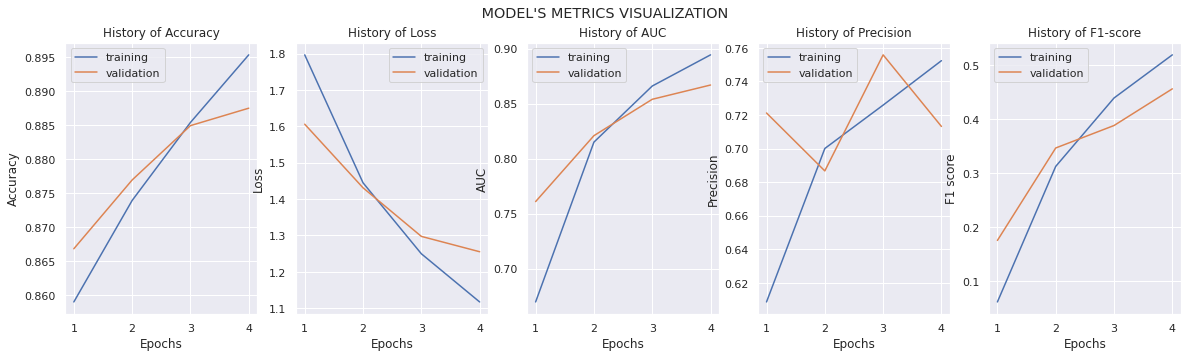

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'],
               history1.history['auc'],history1.history['val_auc'],
               history1.history['precision'],history1.history['val_precision'],
               history1.history['f1_score'],history1.history['val_f1_score']
              )

We can conclude from these visualizations that the model overfits more quickly than the previous model trained with data augmentation over the same number of epochs, as most metrics show higher values on the training set compared to the validation set, especially towards the fourth epoch.

In [ ]:
# Evaluate the model on the test set
results = model_cnn_WA.evaluate(test_dataset, verbose=1)

132/132 [==============================] - 16s 118ms/step - loss: 1.1636 - accuracy: 0.8939 - precision: 0.7353 - recall: 0.4017 - auc: 0.8851 - f1_score: 0.4955


===> We followed two different approaches for the CNN model training; in the first approach, data augmentation was applied, which creates variations of the original images. This helps prevent overfitting by making the model learn from a wider range of data. In the second training, data augmentation was not used, and only the original dataset was provided during the training.<br>Although the two training approaches had approximately similar results metrics-wise on the final test set, the difference in performance becomes evident when visualizing the training and validation metrics. <br>With data augmentation, the metrics followed a stable and consistent trend across epochs, producing the expected results where the values of the validation set were higher than those of the training set. In contrast, without data augmentation, the metrics values of the training set progressed quickly surpassing the values of the validation set at the end indicating that the model is overfitting and this shows the importance of data augmentation for better generalization.


# VGG16 MODEL Training on Emotion Recognition

### Rescaling and splitting into train and validation set

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/train-fer/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle = True)

Found 26957 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/train-fer/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 6736 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/test-2/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 8421 images belonging to 7 classes.


### Downloading the base model to train

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

### Freezing some layers during training
In this step, the earlier layers of a pre-trained model are freezed so their weights won’t be updated during training. This helps retain the previously learned features and focus on adapting the model to the new dataset.

In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

### Building the model

In [ ]:
model_vgg=Sequential()
model_vgg.add(base_model)
model_vgg.add(Dropout(0.5))
model_vgg.add(Flatten())
model_vgg.add(BatchNormalization())
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(32,kernel_initializer='he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(Dense(7,activation='softmax'))

In [ ]:
# Model Summary

model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                16416     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)               

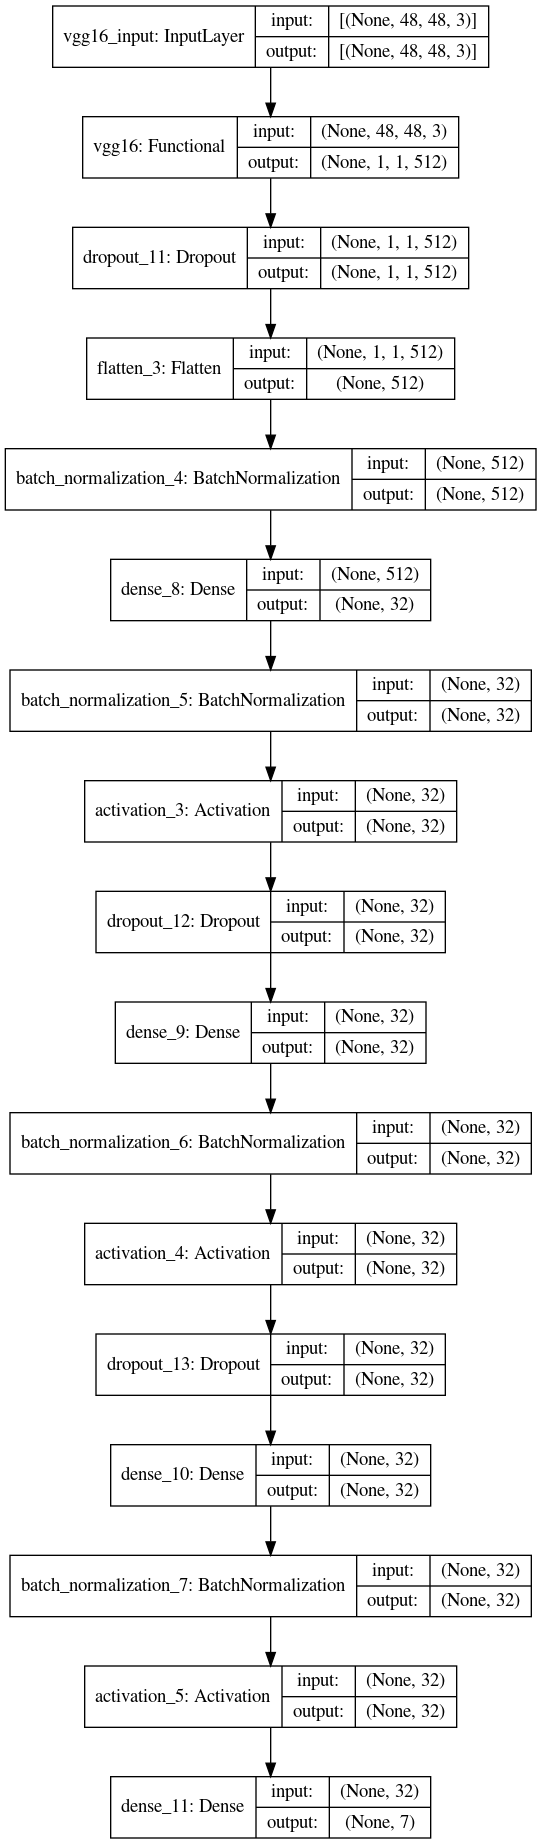

In [ ]:
plot_model(model_vgg, to_file='vgg.png', show_shapes=True,show_layer_names=True)
Image(filename='vgg.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_vgg.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model_vgg.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model_vgg.fit(train_dataset,validation_data=valid_dataset,epochs = 4,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/4
422/422 [==============================] - 574s 1s/step - loss: 1.8408 - accuracy: 0.8572 - precision: 0.5086 - recall: 0.0077 - auc: 0.6449 - f1_score: 0.0149 - val_loss: 2.0270 - val_accuracy: 0.8573 - val_precision: 0.6667 - val_recall: 0.0027 - val_auc: 0.5721 - val_f1_score: 0.0052

Epoch 00001: val_loss did not improve from 1.94520
Epoch 2/4
422/422 [==============================] - 574s 1s/step - loss: 1.7900 - accuracy: 0.8571 - precision: 0.4874 - recall: 0.0093 - auc: 0.6776 - f1_score: 0.0181 - val_loss: 1.9064 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6214 - val_f1_score: 0.0000e+00

Epoch 00002: val_loss improved from 1.94520 to 1.90640, saving model to model.h5
Epoch 3/4
422/422 [==============================] - 572s 1s/step - loss: 1.7486 - accuracy: 0.8581 - precision: 0.5667 - recall: 0.0273 - auc: 0.6984 - f1_score: 0.0518 - val_loss: 1.7812 - val_accuracy: 0.8578 - val_precision: 0.8444 - val_recall: 0.0056 -

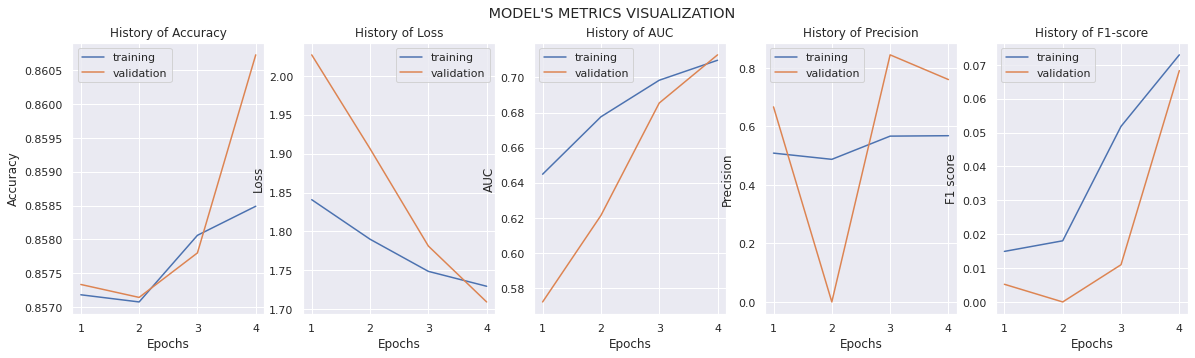

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

### Model Training and Validation Metrics Analysis

The metrics visualization highlights consistent improvements in training and validation accuracy, peaking around 86%, which indicates the model generalizes well. Precision improves significantly over epochs, but recall and F1-score remain low, signaling the model struggles to identify minority classes effectively. Despite decreasing loss and increasing AUC (up to ~0.70), the low recall and F1-score suggest that the model may have challenges in prediction.

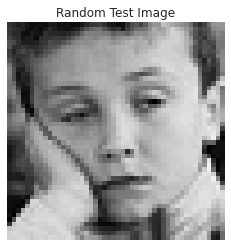

Predicted Class: neutral (Index: 4)
Actual Class: neutral (Index: 4)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get the class indices from the dataset
class_indices = test_dataset.class_indices
class_names = list(class_indices.keys())

# Extract a random batch from the test_dataset
for batch_images, batch_labels in test_dataset:
    # Get a random index within the batch
    random_index = random.randint(0, batch_images.shape[0] - 1)
    random_image = batch_images[random_index]
    random_label = batch_labels[random_index]
    break

# Display the randomly selected image
plt.imshow(random_image)
plt.title("Random Test Image")
plt.axis("off")
plt.show()

# Reshape and scale the image if necessary
random_image = np.expand_dims(random_image, axis=0)

# Predict using the trained model
predictions = model_vgg.predict(random_image)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]

# Get the actual class
actual_class_index = np.argmax(random_label)
actual_class_name = class_names[actual_class_index]

# Display the predicted and actual class names
print(f"Predicted Class: {predicted_class_name} (Index: {predicted_class_index})")
print(f"Actual Class: {actual_class_name} (Index: {actual_class_index})")


In [ ]:
# Evaluate the model on the test set
results = model_vgg.evaluate(test_dataset, verbose=1)

132/132 [==============================] - 97s 732ms/step - loss: 1.6514 - accuracy: 0.8617 - precision: 0.7683 - recall: 0.0461 - auc: 0.7417 - f1_score: 0.0857


# Emotion Detection using ResNet

In [ ]:
import tensorflow as tf

# Create the base ResNet50 model with pre-trained weights
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(48, 48, 3),
    pooling='max',
    classes=7,
    weights='imagenet'
)

# Freeze all layers except the last 4 in the base model
for layer in pretrained_model.layers[:-4]:
    layer.trainable = False

# Create the final model
resnet_model = tf.keras.models.Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)))
resnet_model.add(tf.keras.layers.Dropout(0.6))
resnet_model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)))
resnet_model.add(tf.keras.layers.Dense(7, activation='softmax'))

# Print model summary to verify
resnet_model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                49176     
_________________________________________________________________
dropout_14 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 175       
Total params: 23,637,663
Trainable params: 54,047
Non-t

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Compile the model with the previously defined METRICS
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Callbacks
lrd = ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor=0.50, min_lr=1e-10)
mcp = ModelCheckpoint('model.h5', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

# Train the model using the data generators
history3 = resnet_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=4,
    callbacks=[lrd, mcp, es],
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    validation_steps=valid_dataset.samples // valid_dataset.batch_size
)


Epoch 1/4
421/421 [==============================] - 165s 382ms/step - loss: 3.6642 - accuracy: 0.8568 - precision: 0.1833 - recall: 6.4827e-04 - auc: 0.5189 - f1_score: 0.0036 - val_loss: 1.9823 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5115 - val_f1_score: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.98232, saving model to model.h5
Epoch 2/4
421/421 [==============================] - 160s 381ms/step - loss: 1.9629 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5066 - f1_score: 0.0000e+00 - val_loss: 1.9456 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5100 - val_f1_score: 0.0000e+00

Epoch 00002: val_loss improved from 1.98232 to 1.94557, saving model to model.h5
Epoch 3/4
421/421 [==============================] - 161s 382ms/step - loss: 1.9454 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5110 - f1_score: 0.0000e+00 - val_loss: 1

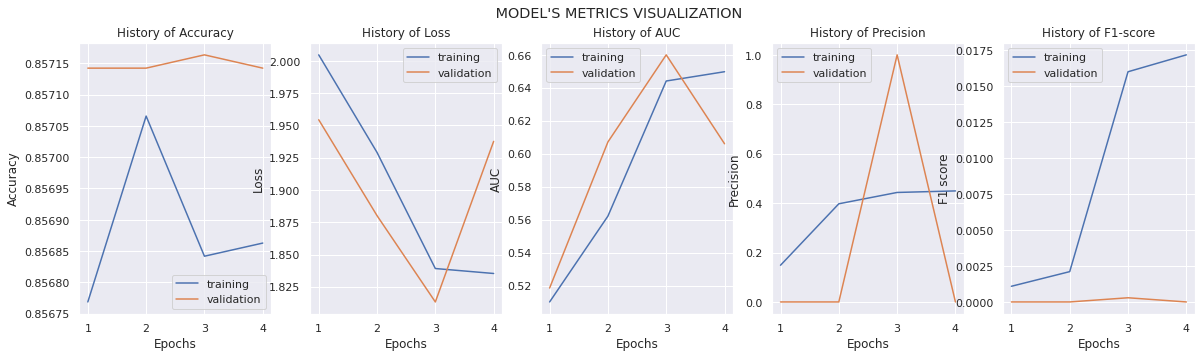

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

===> The visualization showcases the training and validation metrics across four epochs, revealing trends in accuracy, loss, AUC, precision, and F1-score. While training metrics improve steadily, validation metrics exhibit fluctuations, suggesting that the model may encounter issues while predicting the classes.

### Example of the model Prediction

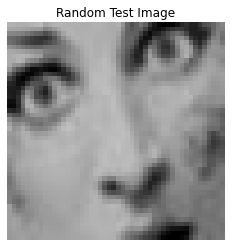

Predicted Class: surprise (Index: 6)
Actual Class: surprise (Index: 6)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get the class indices from the dataset
class_indices = test_dataset.class_indices
class_names = list(class_indices.keys())

# Extract a random batch from the test_dataset
for batch_images, batch_labels in test_dataset:
    # Get a random index within the batch
    random_index = random.randint(0, batch_images.shape[0] - 1)
    random_image = batch_images[random_index]
    random_label = batch_labels[random_index]
    break  # Stop after fetching the first batch

# Display the randomly selected image
plt.imshow(random_image)
plt.title("Random Test Image")
plt.axis("off")
plt.show()

# Reshape and scale the image if necessary
random_image = np.expand_dims(random_image, axis=0)

# Predict using the trained model
predictions = resnet_model.predict(random_image)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]

# Get the actual class
actual_class_index = np.argmax(random_label)
actual_class_name = class_names[actual_class_index]

# Display the predicted and actual class names
print(f"Predicted Class: {predicted_class_name} (Index: {predicted_class_index})")
print(f"Actual Class: {actual_class_name} (Index: {actual_class_index})")


In [ ]:
# Evaluate the model on the test set
results = resnet_model.evaluate(test_dataset, verbose=1)

132/132 [==============================] - 39s 292ms/step - loss: 1.9471 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4987 - f1_score: 0.0000e+00


# Final evaluation of the models

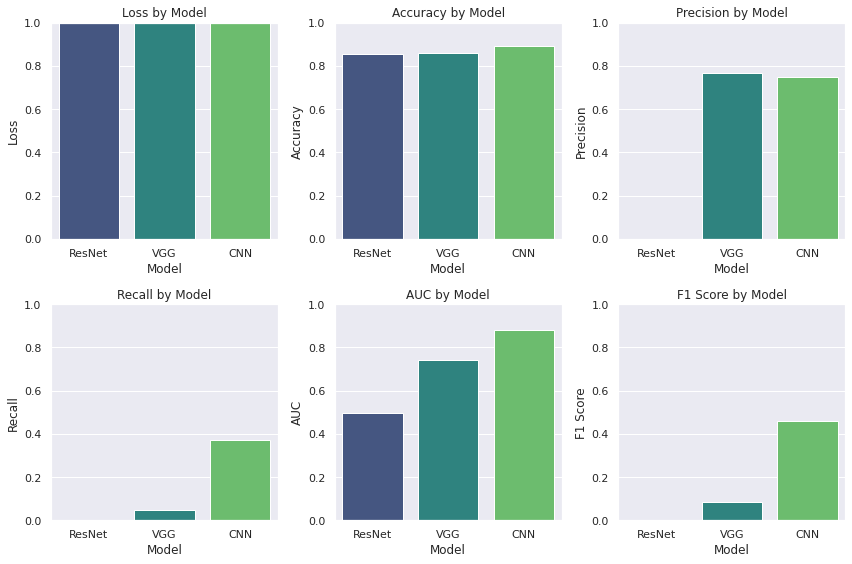

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Updated metrics for each model
data = {
    'Model': ['ResNet', 'VGG', 'CNN'],
    'Loss': [1.9471, 1.6514, 1.1786],
    'Accuracy': [0.8571, 0.8617, 0.8922],
    'Precision': [0.0000, 0.7683, 0.7475],
    'Recall': [0.0000, 0.0461, 0.3705],
    'AUC': [0.4987, 0.7417, 0.8810],
    'F1 Score': [0.0000, 0.0857, 0.4610]
}

df = pd.DataFrame(data)

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Plot each metric separately using seaborn
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score']

for idx, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, idx)
    sns.barplot(x='Model', y=metric, data=df, palette='viridis')
    plt.title(f'{metric} by Model')
    plt.ylim(0, 1)  # Setting the same y-limit for better comparison

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Model Comparison and Conclusion

#### 1. **Accuracy:**
   - **CNN** achieved the highest accuracy at 0.8922, followed by **VGG** at 0.8617, and **ResNet** with the lowest accuracy at 0.8571.

#### 2. **Loss:**
   - **CNN** has the lowest loss value at 1.1786, followed by **VGG** at 1.6514, and **ResNet** with the highest loss value at 1.9471.

#### 3. **Precision:**
   - **VGG** outperforms other models in precision at 0.7683, followed by **CNN** at 0.7475. **ResNet** has no precision score (0.0000).

#### 4. **Recall:**
   - **CNN** has the highest recall value at 0.3705, followed by **VGG** at 0.0461, and **ResNet** with no recall score (0.0000).

#### 5. **AUC (Area Under Curve):**
   - **CNN** also leads in AUC with 0.8810, followed by **VGG** at 0.7417, and **ResNet** with the lowest AUC at 0.5000.

#### 6. **F1 Score:**
   - **CNN** scores the highest F1 score at 0.4610, followed by **VGG** at 0.0857, and **ResNet** with no F1 score (0.0000).

---

### **Overall Conclusion:**
- **CNN** consistently outperforms both **VGG** and **ResNet** across all metrics, with the highest accuracy, recall, AUC, and F1 score, along with the lowest loss.
- **VGG** performs well in precision but struggles with recall, AUC, and F1 score, and shows higher loss compared to CNN.
- **ResNet** doesn't perform well in most metrics, particularly in precision, recall, F1 score, and AUC.

**Final Model Ranking:**
1. **CNN** (Best performer overall)
2. **VGG**
3. **ResNet** (Least effective model)
